# Portable long-term zone comfort analytics
Brick metadata schema enables portable data analytics in building science. This IPython notebook uses this technology to evalute long-term thermal comfort over 107 buildings in Mortar Database.  
Aug. 2021

## Initiate Mortar API

In [25]:
import pymortar
import pandas as pd
import re
from hourly_outlier import *
from app import *

# display all content in a pd df column and discard warning info
pd.set_option('display.max_colwidth', None)
pd.set_option('mode.chained_assignment', None)
# connect client to Mortar frontend server
client = pymortar.Client("https://beta-api.mortardata.org")

In [26]:
!pip install pymortar==2.0.5

In [30]:
!pip show pymortar

Name: pymortar
Version: 2.0.5
Summary: 
Home-page: None
Author: Gabe Fierro
Author-email: gtfierro@cs.berkeley.edu
License: None
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: pyarrow, toml, python-snappy, pandas, googleapis-common-protos, brickschema, requests, rdflib
Required-by: 


In [21]:
# airflow_query = """SELECT ?airflow ?vav ?zone WHERE {
#     ?airflow a brick:Air_Flow_Sensor .
#     ?airflow brick:isPointOf ?vav .
#     ?vav brick:feeds ?zone .
#     ?zone a brick:HVAC_Zone .
# }"""
# qualify_resp = client.qualify([airflow_query])

## Write a query using Brick

In [22]:
query = """SELECT ?sensor WHERE {{
    ?sensor a brick:Zone_Air_Temperature_Sensor .
}}"""

In [45]:
# define each entity and relationships between them
query = """SELECT ?sensor ?zone ?vav ?room ?floor ?ahu WHERE {{
    ?sensor a brick:Zone_Air_Temperature_Sensor .
    ?sensor brick:isPointOf ?vav .
    ?vav brick:feeds ?zone .
    ?zone a brick:HVAC_Zone .
    ?zone brick:hasPart ?room .
    ?room a brick:Room .
    ?room brick:isPartOf ?floor .
    ?floor a brick:Floor .
    ?ahu a brick:AHU .
    ?ahu brick:feeds ?vav .
}}"""


In [46]:
# get which sites return results for the query above
qualify_resp = client.qualify([query])
print("Mortar has {0} qualifed sites".format(len(qualify_resp.sites)))
print(qualify_resp.sites)

Mortar has 25 qualifed sites
['artx', 'bwfp', 'chem', 'chemx', 'crus', 'dh', 'fdpd', 'gbsf', 'gha_ics', 'giedt', 'hart', 'hwc', 'mann', 'msb', 'music', 'roes', 'stor', 'thur', 'veih', 'vm3a', 'vmep', 'vmif', 'vmth', 'well', 'wsrc']


In [18]:
# # query outside air temperature sensor
# query = """SELECT ?sensor WHERE {{
#     ?sensor a brick:Zone_Air_Temperature_Sensor .
# }}"""

In [47]:
# get the metadata of the query at a specific site
metadata_vmif = client.sparql(query, sites=['wsrc'])

## Download the zone air temperature sensor data at zone 2063_

In [48]:
metadata_vmif

,sensor,zone,vav,room,floor,ahu,site
0,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2211,http://buildsys.org/ontologies/WSRC#VAVRM2211,http://buildsys.org/ontologies/WSRC#RM2211_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
1,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2209_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2209_MIX,http://buildsys.org/ontologies/WSRC#VAVRM2209_MIX,http://buildsys.org/ontologies/WSRC#RM2209_MIX_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
2,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2100.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2100,http://buildsys.org/ontologies/WSRC#VAVRM2100,http://buildsys.org/ontologies/WSRC#RM2100_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
3,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2112_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2112_MIX,http://buildsys.org/ontologies/WSRC#VAVRM2112_MIX,http://buildsys.org/ontologies/WSRC#RM2112_MIX_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
4,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2109.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2109,http://buildsys.org/ontologies/WSRC#VAVRM2109,http://buildsys.org/ontologies/WSRC#RM2109_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
5,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2202.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2202,http://buildsys.org/ontologies/WSRC#VAVRM2202,http://buildsys.org/ontologies/WSRC#RM2202_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
6,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2205_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2205_MIX,http://buildsys.org/ontologies/WSRC#VAVRM2205_MIX,http://buildsys.org/ontologies/WSRC#RM2205_MIX_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
7,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2202_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2202_MIX,http://buildsys.org/ontologies/WSRC#VAVRM2202_MIX,http://buildsys.org/ontologies/WSRC#RM2202_MIX_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
8,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2112.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2112,http://buildsys.org/ontologies/WSRC#VAVRM2112,http://buildsys.org/ontologies/WSRC#RM2112_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc
9,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2107_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/WSRC#RM2107_MIX,http://buildsys.org/ontologies/WSRC#VAVRM2107_MIX,http://buildsys.org/ontologies/WSRC#RM2107_MIX_room,http://buildsys.org/ontologies/WSRC#floor2,http://buildsys.org/ontologies/WSRC#AHU03,wsrc


In [49]:
md = 'http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp'
data_sensor = client.data_uris([md])
data_sensor.data

,time,value,id
0,2012-04-18 23:45:00+00:00,70.50,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
1,2012-04-18 23:30:00+00:00,70.75,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
2,2012-04-18 23:15:00+00:00,70.75,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
3,2012-04-18 23:00:00+00:00,70.75,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
4,2012-04-18 22:45:00+00:00,70.75,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
...,...,...,...
225401,2017-11-30 16:45:00+00:00,76.00,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
225402,2017-11-30 16:30:00+00:00,76.00,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
225403,2017-11-30 16:15:00+00:00,76.00,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp
225404,2017-11-30 16:00:00+00:00,76.00,http://buildsys.org/ontologies/WSRC#WSRC.ZONE.AHU03.RM2211.Zone_Air_Temp


## Evaluate at all zones at a site

In [41]:
# assign values to index function input variables
md = 'tbd'
sd = '2016-1-1'
ed = '2016-12-31'
sh = 9
eh = 17
sl = 71.6
su = 80.6
wl = 66.2
wu = 77.0

In [42]:
# loop through all zones at the site
res_data = []
for idxi, row in metadata_vmif.iterrows():
    res_row = {}
    md = row.sensor
    p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
    for k in metadata_vmif.columns:
        res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
    res_row['room'] = re.split('RM(.+)_room', row.room)[-2]
    res_row['index'] = p
    res_data += [res_row]
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

,sensor,zone,vav,room,floor,ahu,site,index
0,Zon_Air_Temp,RM2004,VAVRM2004,2004,floor2,AHU01,vmif,1.0
165,Zon_Air_Temp,RM2047,VAVRM2047,2047,floor2,AHU02,vmif,1.0
156,Zon_Air_Temp,RM1044,VAVRM1044,1044,floor1,AHU02,vmif,1.0
157,Zon_Air_Temp,RM1020_3,VAVRM1020_3,1020_3,floor1,AHU01,vmif,1.0
80,Zon_Air_Temp,RM1006,VAVRM1006,1006,floor1,AHU01,vmif,1.0
...,...,...,...,...,...,...,...,...
79,Zon_Air_Temp,RM2071B,VAVRM2071B,2071B,floor2,AHU02,vmif,0.0
77,Zon_Air_Temp,RM1047,VAVRM1047,1047,floor1,AHU02,vmif,0.0
75,Zon_Air_Temp,RM2045,VAVRM2045,2045,floor2,AHU02,vmif,0.0
71,Zon_Air_Temp,RM2071,VAVRM2071,2071,floor2,AHU02,vmif,0.0


## Evalute group by floor

In [22]:
# get which floors return results for the query above
qualify_plus(metadata_vmif, 'floor')

[rdflib.term.URIRef('http://buildsys.org/ontologies/VMIF#floor1'),
 rdflib.term.URIRef('http://buildsys.org/ontologies/VMIF#floor2')]

In [23]:
# loop through all the zones on the floor 1
group = 'floor'
res_data = []
for idxi, row in metadata_vmif.iterrows():
    if row[group] == qualify_plus(metadata_vmif, group)[0]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_vmif.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['room'] = re.split('RM(.+)_room', row.room)[-2]
        res_row['index'] = p
        res_data += [res_row]
floor1_df = pd.DataFrame(res_data)
floor1_df_s = floor1_df.sort_values(['index'], ascending=[False])
floor1_df_s

,sensor,zone,vav,room,floor,ahu,site,index
2,Zon_Air_Temp,RM1030_1,VAVRM1030_1,1030_1,floor1,AHU02,vmif,0.79
3,Zon_Air_Temp,RM1030,VAVRM1030,1030,floor1,AHU02,vmif,0.55
4,Zon_Air_Temp,RM1006,VAVRM1006,1006,floor1,AHU01,vmif,0.55
15,Zon_Air_Temp,RM1044,VAVRM1044,1044,floor1,AHU02,vmif,0.50
6,Zon_Air_Temp,RM1048,VAVRM1048,1048,floor1,AHU02,vmif,0.50
...,...,...,...,...,...,...,...,...
8,Zon_Air_Temp,RM1052C,VAVRM1052C,1052C,floor1,AHU02,vmif,0.17
30,Zon_Air_Temp,RM1003_1,VAVRM1003_1,1003_1,floor1,AHU01,vmif,0.11
17,Zon_Air_Temp,RM1008,VAVRM1008,1008,floor1,AHU02,vmif,0.04
26,Zon_Air_Temp,RM1003_3,VAVRM1003_3,1003_3,floor1,AHU02,vmif,0.00


In [24]:
# loop through all the zones on the floor 2
group = 'floor'
res_data = []
for idxi, row in metadata_vmif.iterrows():
    if row[group] == qualify_plus(metadata_vmif, group)[1]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_vmif.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['room'] = re.split('RM(.+)_room', row.room)[-2]
        res_row['index'] = p
        res_data += [res_row]
floor2_df = pd.DataFrame(res_data)
floor2_df_s = floor2_df.sort_values(['index'], ascending=[False])


In [30]:
pd.set_option('display.max_rows', 10)
floor1_df_s

,sensor,zone,vav,room,floor,ahu,site,index
2,Zon_Air_Temp,RM1030_1,VAVRM1030_1,1030_1,floor1,AHU02,vmif,0.79
3,Zon_Air_Temp,RM1030,VAVRM1030,1030,floor1,AHU02,vmif,0.55
4,Zon_Air_Temp,RM1006,VAVRM1006,1006,floor1,AHU01,vmif,0.55
15,Zon_Air_Temp,RM1044,VAVRM1044,1044,floor1,AHU02,vmif,0.50
6,Zon_Air_Temp,RM1048,VAVRM1048,1048,floor1,AHU02,vmif,0.50
...,...,...,...,...,...,...,...,...
8,Zon_Air_Temp,RM1052C,VAVRM1052C,1052C,floor1,AHU02,vmif,0.17
30,Zon_Air_Temp,RM1003_1,VAVRM1003_1,1003_1,floor1,AHU01,vmif,0.11
17,Zon_Air_Temp,RM1008,VAVRM1008,1008,floor1,AHU02,vmif,0.04
26,Zon_Air_Temp,RM1003_3,VAVRM1003_3,1003_3,floor1,AHU02,vmif,0.00


In [31]:
floor1_order = floor1_df_s.room.tolist()
floor1_order

['1030_1',
 '1030',
 '1006',
 '1044',
 '1048',
 '1042',
 '1005',
 '1052',
 '1040A',
 '1056',
 '1020_1',
 '1043',
 '1041',
 '1047',
 '1030C',
 '1030_2',
 '1030_3',
 '1010',
 '1013',
 '1024',
 '1020C',
 '1020_2',
 '1011',
 '1020',
 '1001',
 '1020_3',
 '1003_4',
 '1052B',
 '1052C',
 '1003_1',
 '1008',
 '1003_3',
 '1003_2']

## Plot boxplot for all zones at a floor

In [25]:
# get all zone air temperature data on the floor 1 for plot
group = 'floor'
res_s = pd.DataFrame()
res_w = pd.DataFrame()

for idxi, row in metadata_vmif.iterrows():
    if row[group] == qualify_plus(metadata_vmif, group)[0]:
        md = row.sensor
        data_sensor = client.data_uris([md])
        data = data_sensor.data
        # get a pandas dataframe between start date and end date of the data
        sd_ns = pd.to_datetime(sd, unit='ns', utc=True)
        ed_ns = pd.to_datetime(ed, unit='ns', utc=True)
        df = data[(data['time'] >= sd_ns) & (data['time'] <= ed_ns)]
        # parse the hour and weekday info and add it as a column
        df['hr'] = pd.to_datetime(df['time']).dt.hour
        df['wk'] = pd.to_datetime(df['time']).dt.dayofweek
        df['mo'] = pd.to_datetime(df['time']).dt.month
        # create occupied df by normal office hours and by weekdays
        df_occ = df[(df['hr'] >= sh) & (df['hr'] < eh) &
                    (df['wk'] >= 0) & (df['wk'] <= 4)]
        # split the occupied data to the summer and  winter
        df_occ_sum = df_occ[(df_occ['mo'] >= 6) & (df_occ['mo'] <= 8)]
        df_occ_win = df_occ[(df_occ['mo'] >= 12) | (df_occ['mo'] <= 2)]
#         # concatenate df_occ_sum and df_occ_win
#         df_occ_sw = pd.concat([df_occ_sum[['value']], df_occ_win[['value']]], axis=0)
        name = re.split('RM(.+)_room', row.room)[-2]
        df_occ_s = df_occ_sum[['value']].rename({'value': name}, axis=1)
        df_occ_w = df_occ_win[['value']].rename({'value': name}, axis=1)
        # store the dataframe into a new column
        res_s = pd.concat([res_s, df_occ_s], axis=1)
        res_w = pd.concat([res_w, df_occ_w], axis=1)

In [26]:
pd.set_option('display.max_rows', 10)
res_s

,1047,1020C,1030_1,1030,1006,1043,1048,1020,1052C,1005,...,1011,1041,1013,1003_3,1010,1020_1,1003_2,1003_1,1042,1030_2
8690,NaN,72.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,74.75,NaN,74.5,NaN,NaN,72.0,NaN,NaN,NaN,NaN
8691,NaN,72.25,NaN,NaN,72.25,NaN,NaN,NaN,NaN,NaN,...,74.75,NaN,74.5,NaN,73.5,72.0,NaN,NaN,NaN,NaN
8692,NaN,72.25,68.75,NaN,72.25,NaN,68.25,NaN,NaN,70.5,...,74.75,NaN,74.5,NaN,73.5,72.0,NaN,75.0,68.25,70.25
8693,NaN,72.25,68.75,NaN,72.25,NaN,68.25,NaN,NaN,70.5,...,74.75,NaN,75.0,NaN,73.5,72.0,NaN,75.0,68.25,70.25
8694,NaN,72.25,68.75,NaN,72.25,NaN,68.25,NaN,NaN,70.5,...,74.75,NaN,75.0,NaN,73.5,72.0,NaN,75.0,68.25,70.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242471,NaN,NaN,NaN,71.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242472,NaN,NaN,NaN,70.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242473,NaN,NaN,NaN,70.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
242474,NaN,NaN,NaN,70.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
res_w

,1047,1020C,1030_1,1030,1006,1043,1048,1020,1052C,1005,...,1011,1041,1013,1003_3,1010,1020_1,1003_2,1003_1,1042,1030_2
17406,NaN,71.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,69.25,NaN,70.0,NaN,NaN,65.25,NaN,NaN,NaN,NaN
17407,NaN,71.5,NaN,NaN,67.25,NaN,NaN,NaN,NaN,NaN,...,69.25,NaN,70.0,NaN,72.25,65.25,NaN,NaN,NaN,NaN
17408,NaN,71.5,NaN,NaN,67.25,NaN,NaN,NaN,NaN,NaN,...,69.25,NaN,70.0,NaN,72.25,65.25,NaN,71.5,NaN,NaN
17409,NaN,71.5,NaN,NaN,67.25,NaN,NaN,NaN,NaN,NaN,...,69.25,NaN,70.0,NaN,71.75,65.25,NaN,71.5,NaN,NaN
17410,NaN,71.5,NaN,NaN,67.25,NaN,NaN,NaN,NaN,NaN,...,69.25,NaN,70.0,NaN,71.75,65.25,NaN,71.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232389,NaN,NaN,NaN,67.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232390,NaN,NaN,NaN,67.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232391,NaN,NaN,NaN,66.4,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
232392,NaN,NaN,NaN,65.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


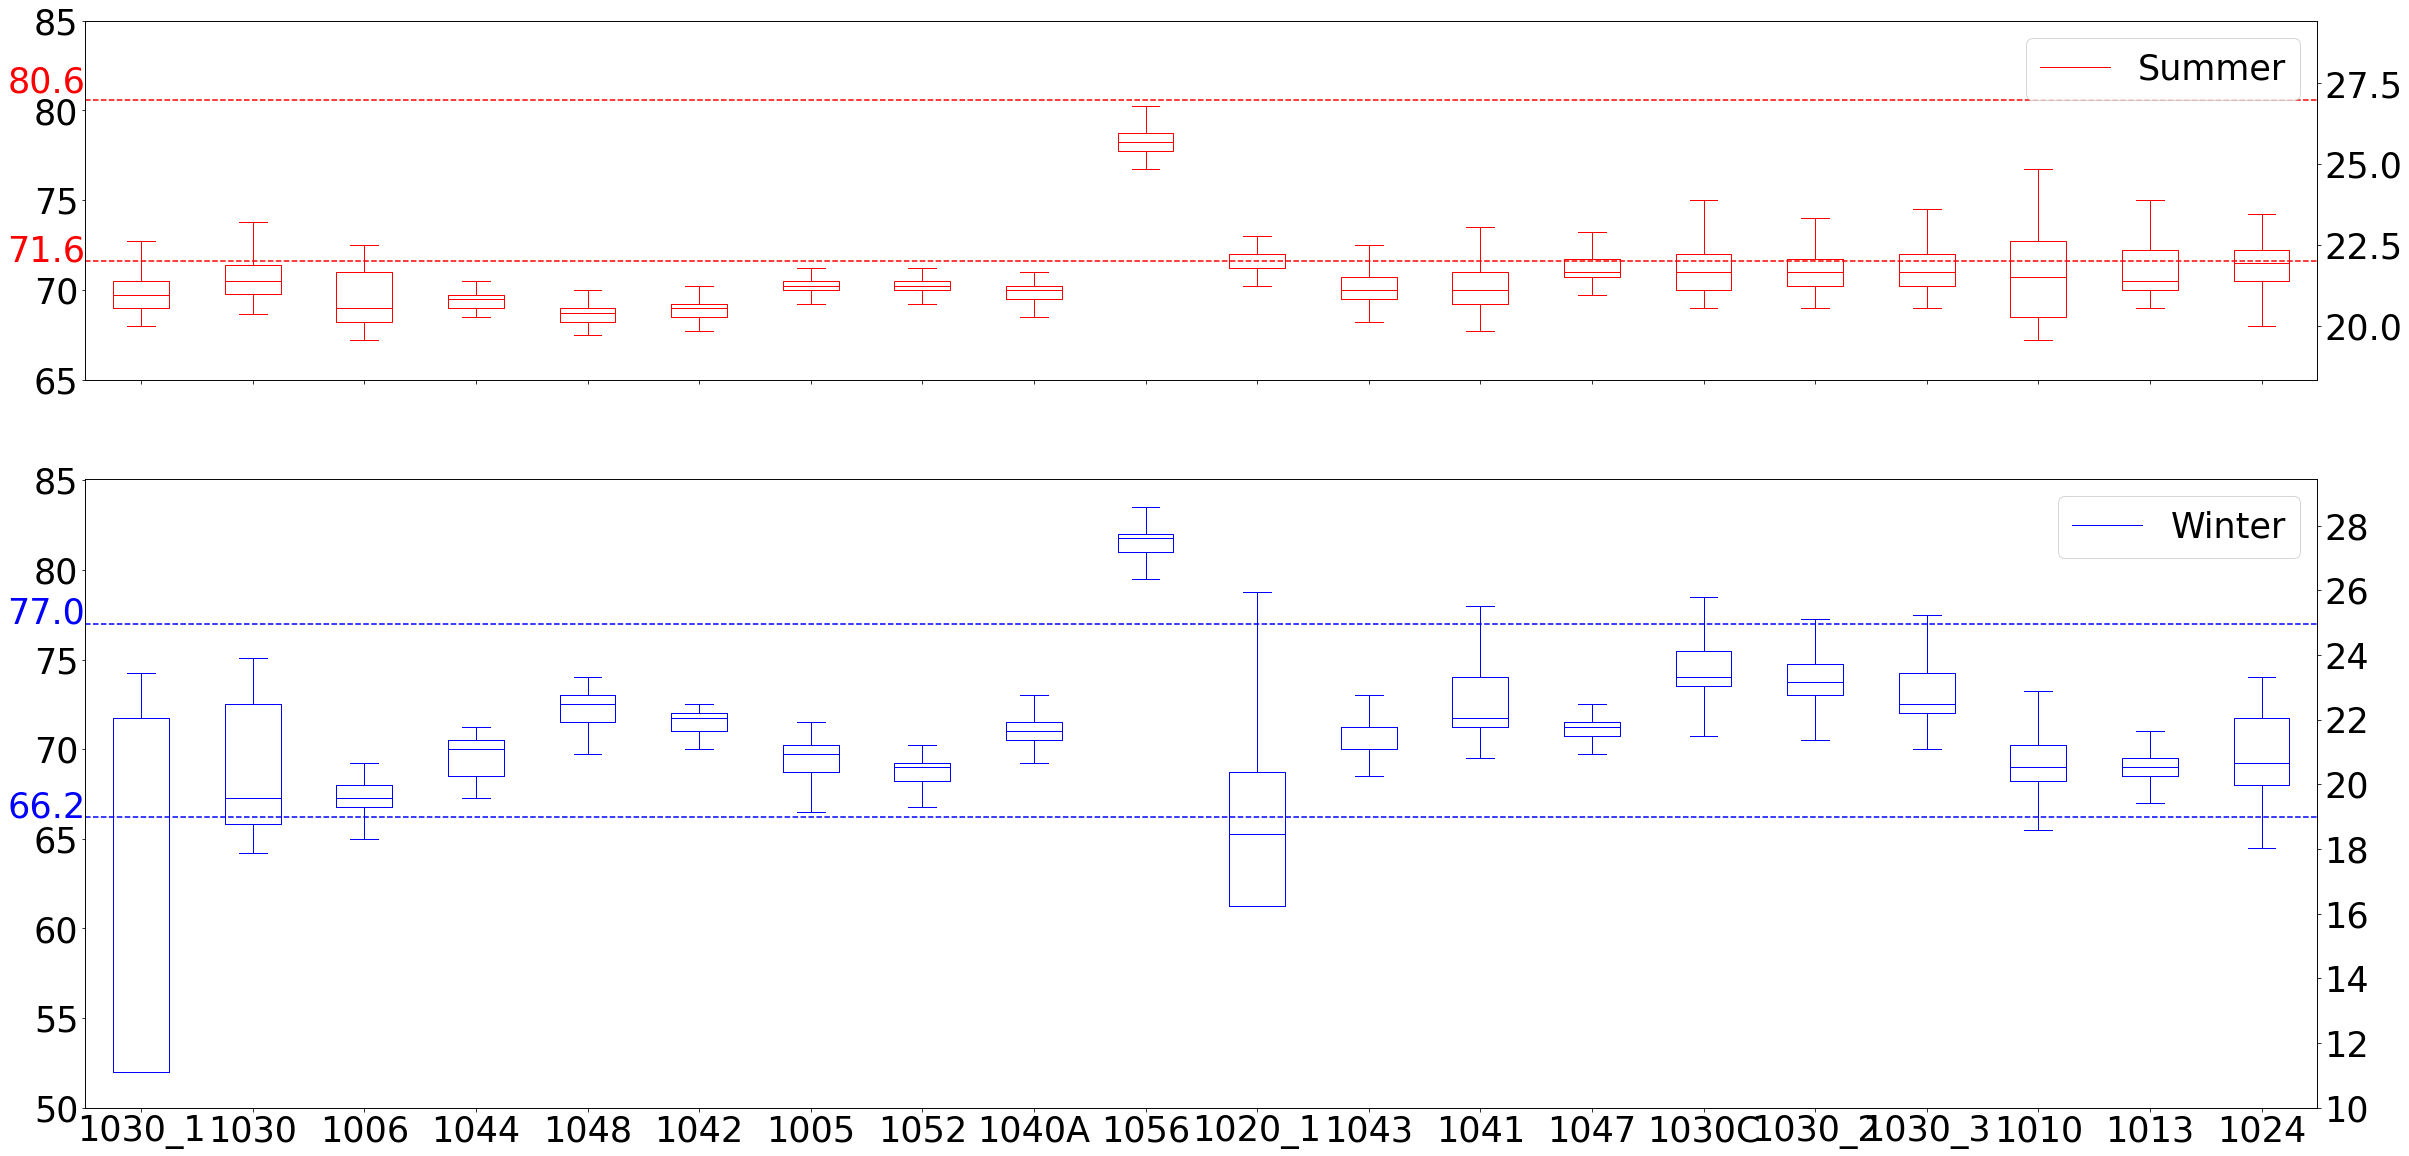

In [32]:
# drop all zeros in the dataframe
res_s = res_s[res_s!= 0]
res_w = res_w[res_w!= 0]
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axes = plt.subplots(2, figsize=(40, 20), gridspec_kw={'height_ratios': [4, 7]})
# plot the summer and winter pandas dataframe
res_s.boxplot(column=floor1_order[0:20], color='red', showfliers=False, ax=axes[0])
res_w.boxplot(column=floor1_order[0:20], color='blue', showfliers=False, ax=axes[1])
# setup the F yaxis and C yaxis
axes[0].set_yticks(np.arange(65, 90, 5))
axes[1].set_yticks(np.arange(50, 90, 5))
axes0_m = axes[0].twinx()
axes1_m = axes[1].twinx()
axes0_m.set_ylim((65-32)/1.8, (85-32)/1.8)
axes1_m.set_ylim((50-32)/1.8, (85-32)/1.8)
axes1_m.yaxis.set_major_locator(MaxNLocator(integer=True))
# change the font size of ytick, and not display the xaxis
axes[0].tick_params(labelbottom=False, labelsize=35)
axes[1].tick_params(labelsize=35)
axes0_m.tick_params(labelsize=35)
axes1_m.tick_params(labelsize=35)
# add the range lines
axes[0].axhline(y=71.6,color='red',linestyle='--')
axes[0].axhline(y=80.6,color='red',linestyle='--')
axes[0].text(-0.2, 71.6, '71.6', fontsize=35, color='red')
axes[0].text(-0.2, 81, '80.6', fontsize=35, color='red')
axes[1].axhline(y=66.2,color='blue',linestyle='--')
axes[1].axhline(y=77.0,color='blue',linestyle='--')
axes[1].text(-0.2, 66.2, '66.2', fontsize=35, color='blue')
axes[1].text(-0.2, 77.0, '77.0', fontsize=35, color='blue')
# add legend
axes[0].legend(["Summer"], fontsize=35, loc='upper right')
axes[1].legend(["Winter"], fontsize=35, loc='upper right')
# turn off the grid
axes[0].grid(False)
axes[1].grid(False)
plt.show()

## thumbnail plots

plotting on artx


2021-10-14:11:30:24,080 WARNING [legend.py:1193] No handles with labels found to put in legend.


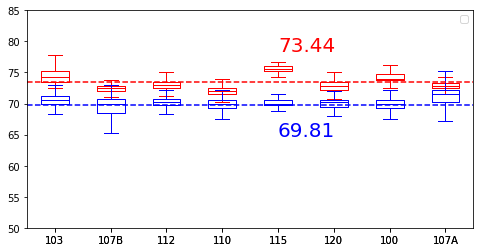

plotting on bwfp


2021-10-14:11:30:49,096 WARNING [legend.py:1193] No handles with labels found to put in legend.


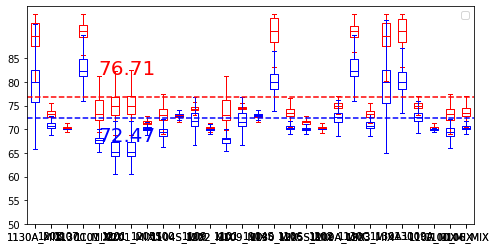

plotting on chem


2021-10-14:11:32:51,481 WARNING [legend.py:1193] No handles with labels found to put in legend.


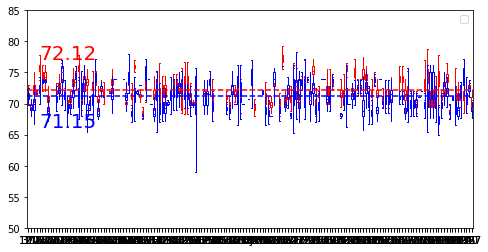

plotting on chemx


2021-10-14:11:34:04,526 WARNING [legend.py:1193] No handles with labels found to put in legend.


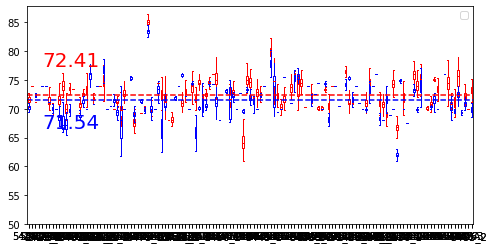

plotting on crus


2021-10-14:11:34:29,215 WARNING [legend.py:1193] No handles with labels found to put in legend.


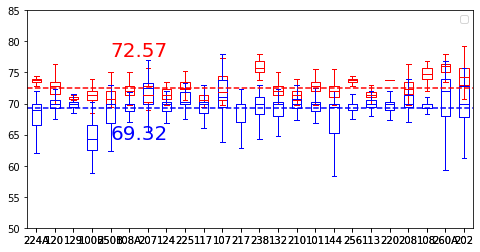

plotting on dh


2021-10-14:11:36:21,024 WARNING [legend.py:1193] No handles with labels found to put in legend.


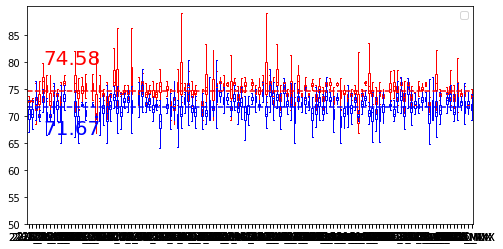

plotting on fdpd


2021-10-14:11:36:38,688 WARNING [legend.py:1193] No handles with labels found to put in legend.


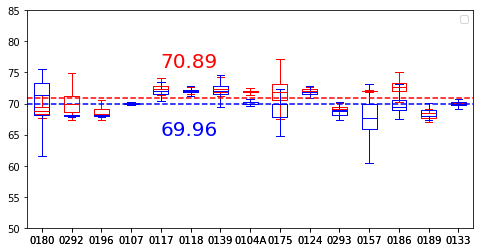

plotting on gbsf


2021-10-14:11:40:39,648 WARNING [legend.py:1193] No handles with labels found to put in legend.


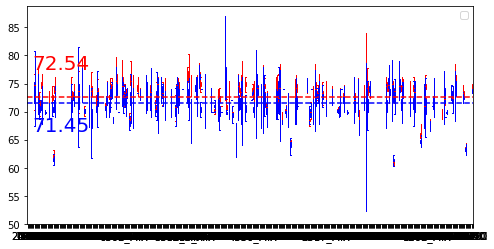

plotting on gha_ics


2021-10-14:11:41:14,182 WARNING [legend.py:1193] No handles with labels found to put in legend.
2021-10-14:11:41:14,864 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:41:14,867 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:41:17,667 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:41:17,669 WARNING [text.py:688] posx and posy should be finite values


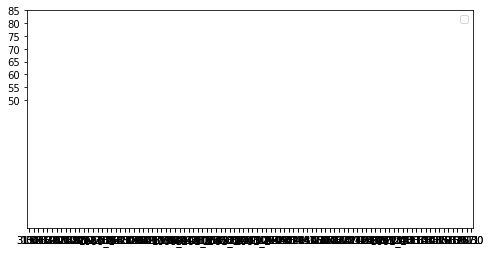

plotting on giedt


2021-10-14:11:41:34,168 WARNING [legend.py:1193] No handles with labels found to put in legend.


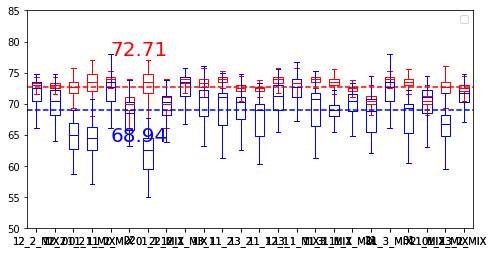

plotting on hart


2021-10-14:11:42:57,332 WARNING [legend.py:1193] No handles with labels found to put in legend.


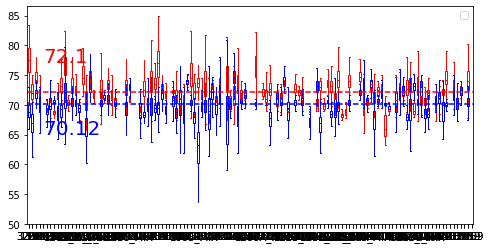

plotting on hwc


2021-10-14:11:44:57,059 WARNING [legend.py:1193] No handles with labels found to put in legend.


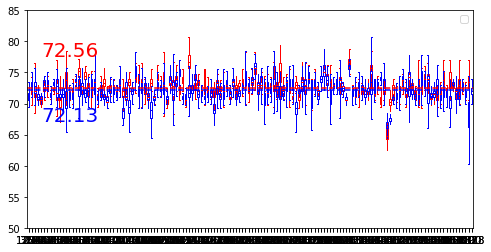

plotting on mann


2021-10-14:11:45:12,617 WARNING [legend.py:1193] No handles with labels found to put in legend.


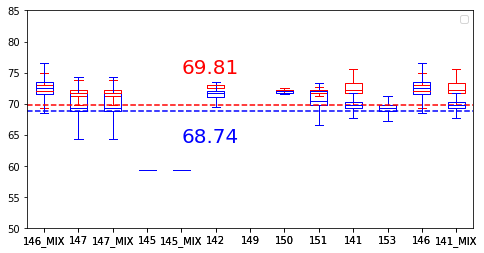

plotting on msb


2021-10-14:11:45:14,543 WARNING [legend.py:1193] No handles with labels found to put in legend.


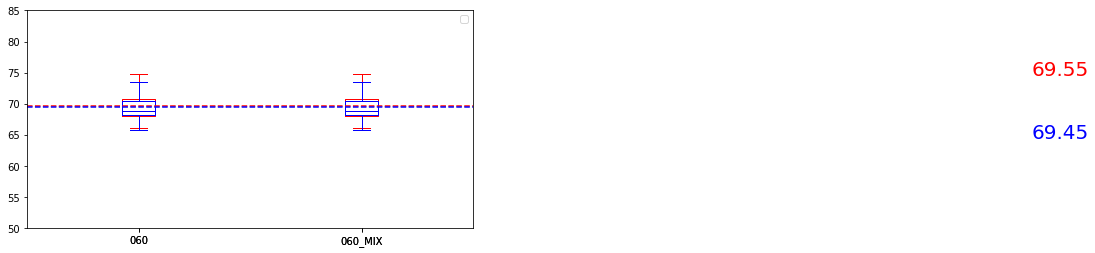

plotting on music


2021-10-14:11:45:16,519 WARNING [legend.py:1193] No handles with labels found to put in legend.


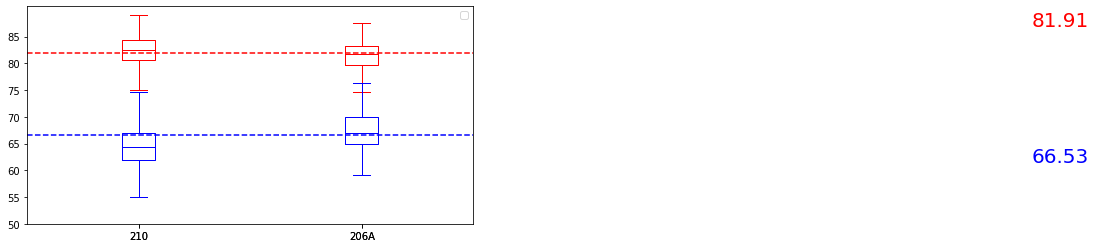

plotting on roes


2021-10-14:11:45:30,766 WARNING [legend.py:1193] No handles with labels found to put in legend.


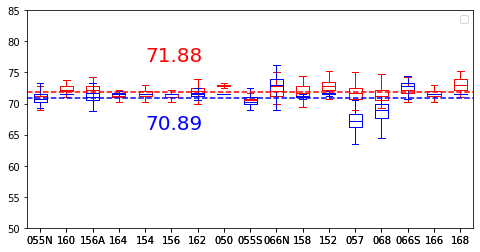

plotting on stor


2021-10-14:11:46:47,758 WARNING [legend.py:1193] No handles with labels found to put in legend.


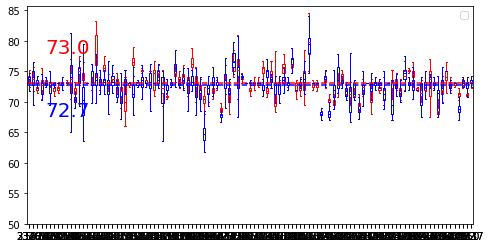

plotting on thur


2021-10-14:11:47:20,713 WARNING [legend.py:1193] No handles with labels found to put in legend.


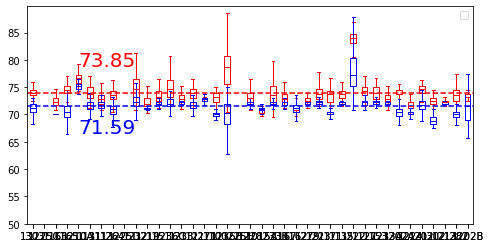

plotting on veih


2021-10-14:11:47:39,493 WARNING [legend.py:1193] No handles with labels found to put in legend.


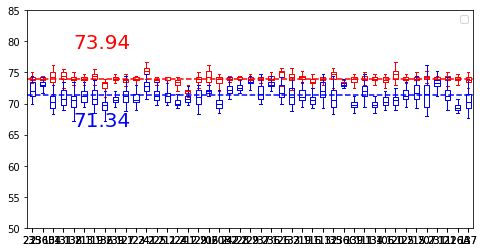

plotting on vm3a


2021-10-14:11:48:47,926 WARNING [legend.py:1193] No handles with labels found to put in legend.
2021-10-14:11:48:50,010 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:48:50,012 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:48:58,125 WARNING [text.py:688] posx and posy should be finite values
2021-10-14:11:48:58,128 WARNING [text.py:688] posx and posy should be finite values


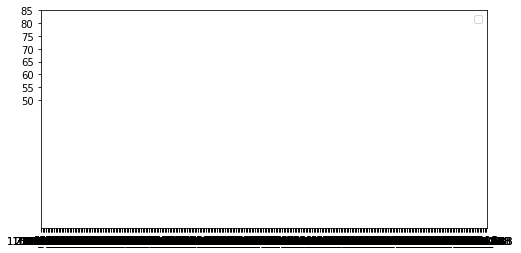

plotting on vmif


2021-10-14:11:50:05,884 WARNING [legend.py:1193] No handles with labels found to put in legend.


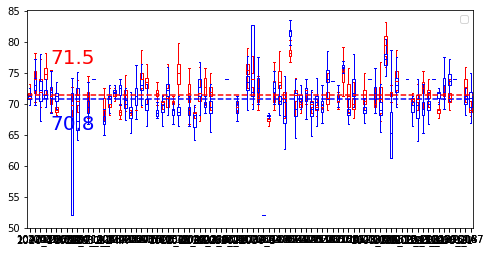

In [11]:
# get all zone air temperature data on the floor 1 for plot
for i in qualify_resp.sites:
    print("plotting on", i)
    metadata_site = client.sparql(query, sites=[i])
    res_s = pd.DataFrame()
    res_w = pd.DataFrame()

    for idxi, row in metadata_site.iterrows():
        md = row.sensor
        data_sensor = client.data_uris([md])
        data = data_sensor.data
        # get a pandas dataframe between start date and end date of the data
        sd_ns = pd.to_datetime(sd, unit='ns', utc=True)
        ed_ns = pd.to_datetime(ed, unit='ns', utc=True)
        df = data[(data['time'] >= sd_ns) & (data['time'] <= ed_ns)]
        # parse the hour and weekday info and add it as a column
        df['hr'] = pd.to_datetime(df['time']).dt.hour
        df['wk'] = pd.to_datetime(df['time']).dt.dayofweek
        df['mo'] = pd.to_datetime(df['time']).dt.month
        # create occupied df by normal office hours and by weekdays
        df_occ = df[(df['hr'] >= sh) & (df['hr'] < eh) &
                    (df['wk'] >= 0) & (df['wk'] <= 4)]
        # split the occupied data to the summer and  winter
        df_occ_sum = df_occ[(df_occ['mo'] >= 6) & (df_occ['mo'] <= 8)]
        df_occ_win = df_occ[(df_occ['mo'] >= 12) | (df_occ['mo'] <= 2)]
    #         # concatenate df_occ_sum and df_occ_win
    #         df_occ_sw = pd.concat([df_occ_sum[['value']], df_occ_win[['value']]], axis=0)
        name = re.split('RM(.+)_room', row.room)[-2]
        df_occ_s = df_occ_sum[['value']].rename({'value': name}, axis=1)
        df_occ_w = df_occ_win[['value']].rename({'value': name}, axis=1)
        # store the dataframe into a new column
        res_s = pd.concat([res_s, df_occ_s], axis=1)
        res_w = pd.concat([res_w, df_occ_w], axis=1)


    # drop all zeros in the dataframe
    res_s = res_s[res_s!= 0]
    res_w = res_w[res_w!= 0]

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.ticker import MaxNLocator

    fig, ax = plt.subplots(1, figsize=(8, 4))
    # plot the summer and winter pandas dataframe
    # , showfliers=False
    res_s.boxplot(color='red', showfliers=False)
    res_w.boxplot(color='blue', showfliers=False)
    # setup the F yaxis and C yaxis
    ax.set_yticks(np.arange(50, 90, 5))
    ax.tick_params(labelsize=10)
    # change the font size of ytick, and not display the xaxis
    # add the range lines
    m_s = res_s.mean().mean()
    m_w = res_w.mean().mean()
    ax.axhline(y=m_s,color='red',linestyle='--')
    ax.axhline(y=m_w,color='blue',linestyle='--')
    ax.text(5, m_s+5, str(round(m_s, 2)), fontsize=20, color='red')
    ax.text(5, m_w-5, str(round(m_w, 2)), fontsize=20, color='blue')
    # add legend
    plt.legend()
    # turn off the grid
    plt.grid(False)
    plt.show()

# evalute group by AHU

In [59]:
# get which AHU return results for the query above
qualify_plus(metadata_hart, 'ahu')

[rdflib.term.URIRef('http://buildsys.org/ontologies/HART#AHU01'),
 rdflib.term.URIRef('http://buildsys.org/ontologies/HART#AHU02')]

In [46]:
# loop through all the spacific floor
group = 'ahu'
res_data = []
for idxi, row in metadata_chem.iterrows():
    if row[group] == qualify_plus(metadata_chem, group)[1]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_chem.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['index'] = p
        res_data += [res_row]
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

,sensor,zone,vav,room,floor,ahu,site,index
3,Zon_Air_Temp,RM270,VAVRM270,RM270_room,floor2,AH2N,chem,0.54
4,Zon_Air_Temp,RM259,VAVRM259,RM259_room,floor2,AH2N,chem,0.52
0,Zon_Air_Temp,RM270,VAVRM270,RM270_room,floor2,AH2N,chem,0.00
1,Zon_Air_Temp,RM259,VAVRM259,RM259_room,floor2,AH2N,chem,0.00
2,Zon_Air_Temp,RM259A,VAVRM259A,RM259A_room,floor2,AH2N,chem,0.00


In [31]:
group = 'ahu'
res_data = []
for idxi, row in metadata_chem.iterrows():
    if row[group] == qualify_plus(metadata_chem, group)[2]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_chem.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['index'] = p
        res_data += [res_row]
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

,sensor,zone,vav,room,floor,ahu,site,index
4,Zon_Air_Temp,RM209,VAVRM209,RM209_room,floor2,AH2S,chem,0.36
2,Zon_Air_Temp,RM225,VAVRM225,RM225_room,floor2,AH2S,chem,0.20
0,Zon_Air_Temp,RM251,VAVRM251,RM251_room,floor2,AH2S,chem,0.00
1,Zon_Air_Temp,RM209,VAVRM209,RM209_room,floor2,AH2S,chem,0.00
3,Zon_Air_Temp,RM225,VAVRM225,RM225_room,floor2,AH2S,chem,0.00
5,Zon_Air_Temp,RM251,VAVRM251,RM251_room,floor2,AH2S,chem,0.00


In [35]:
group = 'ahu'
res_data = []
for idxi, row in metadata_chem.iterrows():
    if row[group] == qualify_plus(metadata_chem, group)[5]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_chem.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['index'] = p
        res_data += [res_row]
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

,sensor,zone,vav,room,floor,ahu,site,index
17,Zon_Air_Temp,RM163I,VAVRM163I,RM163I_room,floor1,AHU01N,chem,0.51
16,Zon_Air_Temp,RM175W,VAVRM175W,RM175W_room,floor1,AHU01N,chem,0.51
15,Zon_Air_Temp,RM163J,VAVRM163J,RM163J_room,floor1,AHU01N,chem,0.51
23,Zon_Air_Temp,RM176,VAVRM176,RM176_room,floor1,AHU01N,chem,0.49
9,Zon_Air_Temp,RM163A,VAVRM163A,RM163A_room,floor1,AHU01N,chem,0.49
...,...,...,...,...,...,...,...,...
4,Zon_Air_Temp,RM163N-B,VAVRM163N-B,RM163N-B_room,floor1,AHU01N,chem,0.00
2,Zon_Air_Temp,RM163C,VAVRM163C,RM163C_room,floor1,AHU01N,chem,0.00
3,Zon_Air_Temp,RM163K,VAVRM163K,RM163K_room,floor1,AHU01N,chem,0.00
8,Zon_Air_Temp,RM163F-B,VAVRM163F-B,RM163F-B_room,floor1,AHU01N,chem,0.00


In [37]:
pd.set_option('display.max_rows', None)
res_df.sort_values(['index'], ascending=[False])

,sensor,zone,vav,room,floor,ahu,site,index
17,Zon_Air_Temp,RM163I,VAVRM163I,RM163I_room,floor1,AHU01N,chem,0.51
16,Zon_Air_Temp,RM175W,VAVRM175W,RM175W_room,floor1,AHU01N,chem,0.51
15,Zon_Air_Temp,RM163J,VAVRM163J,RM163J_room,floor1,AHU01N,chem,0.51
23,Zon_Air_Temp,RM176,VAVRM176,RM176_room,floor1,AHU01N,chem,0.49
9,Zon_Air_Temp,RM163A,VAVRM163A,RM163A_room,floor1,AHU01N,chem,0.49
11,Zon_Air_Temp,RM163K-B,VAVRM163K-B,RM163K-B_room,floor1,AHU01N,chem,0.49
12,Zon_Air_Temp,RM190,VAVRM190,RM190_room,floor1,AHU01N,chem,0.48
1,Zon_Air_Temp,RM163F,VAVRM163F,RM163F_room,floor1,AHU01N,chem,0.47
13,Zon_Air_Temp,RM163E,VAVRM163E,RM163E_room,floor1,AHU01N,chem,0.47
5,Zon_Air_Temp,RM166,VAVRM166,RM166_room,floor1,AHU01N,chem,0.46


In [ ]:
group = 'ahu'
res_data = []
for idxi, row in metadata_chem.iterrows():
    if row[group] == qualify_plus(metadata_chem, group)[6]:
        res_row = {}
        md = row.sensor
        p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
        for k in metadata_chem.columns:
            res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
        res_row['index'] = p
        res_data += [res_row]
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

## Evaluate zone thermal comfort at all sites

In [91]:
# get the brick metadata of the query sensors across all sites, except 'artx'
metadata_all = client.sparql(query, sites=qualify_resp.sites[1:])

In [92]:
metadata_all

,sensor,zone,vav,room,floor,ahu,site
0,http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1130A_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/BWFP#RM1130A_MIX,http://buildsys.org/ontologies/BWFP#VAVRM1130A_MIX,http://buildsys.org/ontologies/BWFP#RM1130A_MIX_room,http://buildsys.org/ontologies/BWFP#floor1,http://buildsys.org/ontologies/BWFP#AHU01,bwfp
1,http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1203.Zone_Air_Temp,http://buildsys.org/ontologies/BWFP#RM1203,http://buildsys.org/ontologies/BWFP#VAVRM1203,http://buildsys.org/ontologies/BWFP#RM1203_room,http://buildsys.org/ontologies/BWFP#floor1,http://buildsys.org/ontologies/BWFP#AHU01,bwfp
2,http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1107.Zone_Air_Temp,http://buildsys.org/ontologies/BWFP#RM1107,http://buildsys.org/ontologies/BWFP#VAVRM1107,http://buildsys.org/ontologies/BWFP#RM1107_room,http://buildsys.org/ontologies/BWFP#floor1,http://buildsys.org/ontologies/BWFP#AHU01,bwfp
3,http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1130C_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/BWFP#RM1130C_MIX,http://buildsys.org/ontologies/BWFP#VAVRM1130C_MIX,http://buildsys.org/ontologies/BWFP#RM1130C_MIX_room,http://buildsys.org/ontologies/BWFP#floor1,http://buildsys.org/ontologies/BWFP#AHU01,bwfp
4,http://buildsys.org/ontologies/BWFP#BWFP.ZONE.AHU01.RM1101_MIX.Zone_Air_Temp,http://buildsys.org/ontologies/BWFP#RM1101_MIX,http://buildsys.org/ontologies/BWFP#VAVRM1101_MIX,http://buildsys.org/ontologies/BWFP#RM1101_MIX_room,http://buildsys.org/ontologies/BWFP#floor1,http://buildsys.org/ontologies/BWFP#AHU01,bwfp
...,...,...,...,...,...,...,...
79,http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM1030_2.Zone_Air_Temp,http://buildsys.org/ontologies/VMIF#RM1030_2,http://buildsys.org/ontologies/VMIF#VAVRM1030_2,http://buildsys.org/ontologies/VMIF#RM1030_2_room,http://buildsys.org/ontologies/VMIF#floor1,http://buildsys.org/ontologies/VMIF#AHU02,vmif
80,http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2001_1.Zone_Air_Temp,http://buildsys.org/ontologies/VMIF#RM2001_1,http://buildsys.org/ontologies/VMIF#VAVRM2001_1,http://buildsys.org/ontologies/VMIF#RM2001_1_room,http://buildsys.org/ontologies/VMIF#floor2,http://buildsys.org/ontologies/VMIF#AHU01,vmif
81,http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU02.RM2061A.Zone_Air_Temp,http://buildsys.org/ontologies/VMIF#RM2061A,http://buildsys.org/ontologies/VMIF#VAVRM2061A,http://buildsys.org/ontologies/VMIF#RM2061A_room,http://buildsys.org/ontologies/VMIF#floor2,http://buildsys.org/ontologies/VMIF#AHU02,vmif
82,http://buildsys.org/ontologies/VMIF#VMIF.ZONE.AHU01.RM2018.Zone_Air_Temp,http://buildsys.org/ontologies/VMIF#RM2018,http://buildsys.org/ontologies/VMIF#VAVRM2018,http://buildsys.org/ontologies/VMIF#RM2018_room,http://buildsys.org/ontologies/VMIF#floor2,http://buildsys.org/ontologies/VMIF#AHU01,vmif


In [93]:
res_data = []
for idxi, row in metadata_all.iterrows():
    res_row = {}
    md = row.sensor
    p = hourly_outlier(md, sd, ed, sh, eh, sl, su, wl, wu)
    for k in metadata_all.columns:
        res_row[k] = 'Zon_Air_Temp' if k == 'sensor' else re.split('[#]', row[k])[-1]
    res_row['index'] = p
    res_data += [res_row]
    print(res_row['site'], p)
res_df = pd.DataFrame(res_data)
res_df.sort_values(['index'], ascending=[False])

bwfp 0.83
bwfp 0.01
bwfp 0.49
bwfp 0.99
bwfp 0.16
bwfp 0.38
bwfp 0.37
bwfp 0.33
bwfp 0.1
bwfp 0.01
bwfp 0.01
bwfp 0.5
bwfp 0.15
bwfp 0.0
bwfp 0.01
bwfp 0.94
bwfp 0.02
bwfp 0.32
bwfp 0.51
bwfp 0.0
bwfp 0.99
bwfp 0.03
bwfp 0.82
bwfp 0.94
bwfp 0.0
bwfp 0.49
bwfp 0.11
bwfp 0.03
chem 0.36
chem 0.51
chem 0.15
chem 0.04
chem 0.0
chem 0.0
chem 0.0
chem 0.42
chem 0
chem 0
chem 0.17
chem 0.01
chem 0.01
chem 0.03
chem 0.55
chem 0.49
chem 0.02
chem 0.0
chem 0.0
chem 0.51
chem 0.01
chem 0.0
chem 0.47
chem 0.08
chem 0.0
chem 0.43
chem 0.04
chem 0.32
chem 0
chem 0.04
chem 0.0
chem 0.0
chem 0
chem 0
chem 0.0
chem 0.46
chem 0.01
chem 0.34
chem 0.0
chem 0.04
chem 0.39
chem 0.5
chem 0.08
chem 0.0
chem 0.49
chem 0.27
chem 0.0
chem 0.34
chem 0.23
chem 0.23
chem 0.49
chem 0.48
chem 0.03
chem 0.03
chem 0.0
chem 0.18
chem 0.2
chem 0.2
chem 0.38
chem 0.47
chem 0.57
chem 0
chem 0
chem 0.09
chem 0.09
chem 0.0
chem 0.36
chem 0
chem 0
chem 0
chem 0
chem 0.45
chem 0.51
chem 0.1
chem 0.27
chem 0.13
chem 0.35
chem 0.

,sensor,zone,vav,room,floor,ahu,site,index
1253,Zon_Air_Temp,RM145_MIX,VAVRM145_MIX,RM145_MIX_room,floor1,AHU06,mann,1.0
853,Zon_Air_Temp,RM2111,VAVRM2111,RM2111_room,floor2,AHU02,gbsf,1.0
580,Zon_Air_Temp,RM1212B,VAVRM1212B,RM1212B_room,floor1,AHU03,gbsf,1.0
296,Zon_Air_Temp,RM2470,VAVRM2470,RM2470_room,floor2,AHU02S,chemx,1.0
653,Zon_Air_Temp,RM1010,VAVRM1010,RM1010_room,floor1,AHU04,gbsf,1.0
...,...,...,...,...,...,...,...,...
860,Zon_Air_Temp,RM6510,VAVRM6510,RM6510_room,floor6,AHU05,gbsf,0.0
861,Zon_Air_Temp,RM3158,VAVRM3158,RM3158_room,floor3,AHU04,gha_ics,0.0
862,Zon_Air_Temp,RM1001,VAVRM1001,RM1001_room,floor1,AHU05,gha_ics,0.0
863,Zon_Air_Temp,RM3035,VAVRM3035,RM3035_room,floor3,AHU03,gha_ics,0.0


## Plot


In [146]:
res_df

,sensor,zone,vav,room,floor,ahu,site,index
0,Zon_Air_Temp,RM1130A_MIX,VAVRM1130A_MIX,RM1130A_MIX_room,floor1,AHU01,bwfp,0.83
1,Zon_Air_Temp,RM1203,VAVRM1203,RM1203_room,floor1,AHU01,bwfp,0.01
2,Zon_Air_Temp,RM1107,VAVRM1107,RM1107_room,floor1,AHU01,bwfp,0.49
3,Zon_Air_Temp,RM1130C_MIX,VAVRM1130C_MIX,RM1130C_MIX_room,floor1,AHU01,bwfp,0.99
4,Zon_Air_Temp,RM1101_MIX,VAVRM1101_MIX,RM1101_MIX_room,floor1,AHU01,bwfp,0.16
...,...,...,...,...,...,...,...,...
1833,Zon_Air_Temp,RM1030_2,VAVRM1030_2,RM1030_2_room,floor1,AHU02,vmif,0.37
1834,Zon_Air_Temp,RM2001_1,VAVRM2001_1,RM2001_1_room,floor2,AHU01,vmif,0.00
1835,Zon_Air_Temp,RM2061A,VAVRM2061A,RM2061A_room,floor2,AHU02,vmif,0.00
1836,Zon_Air_Temp,RM2018,VAVRM2018,RM2018_room,floor2,AHU01,vmif,0.13


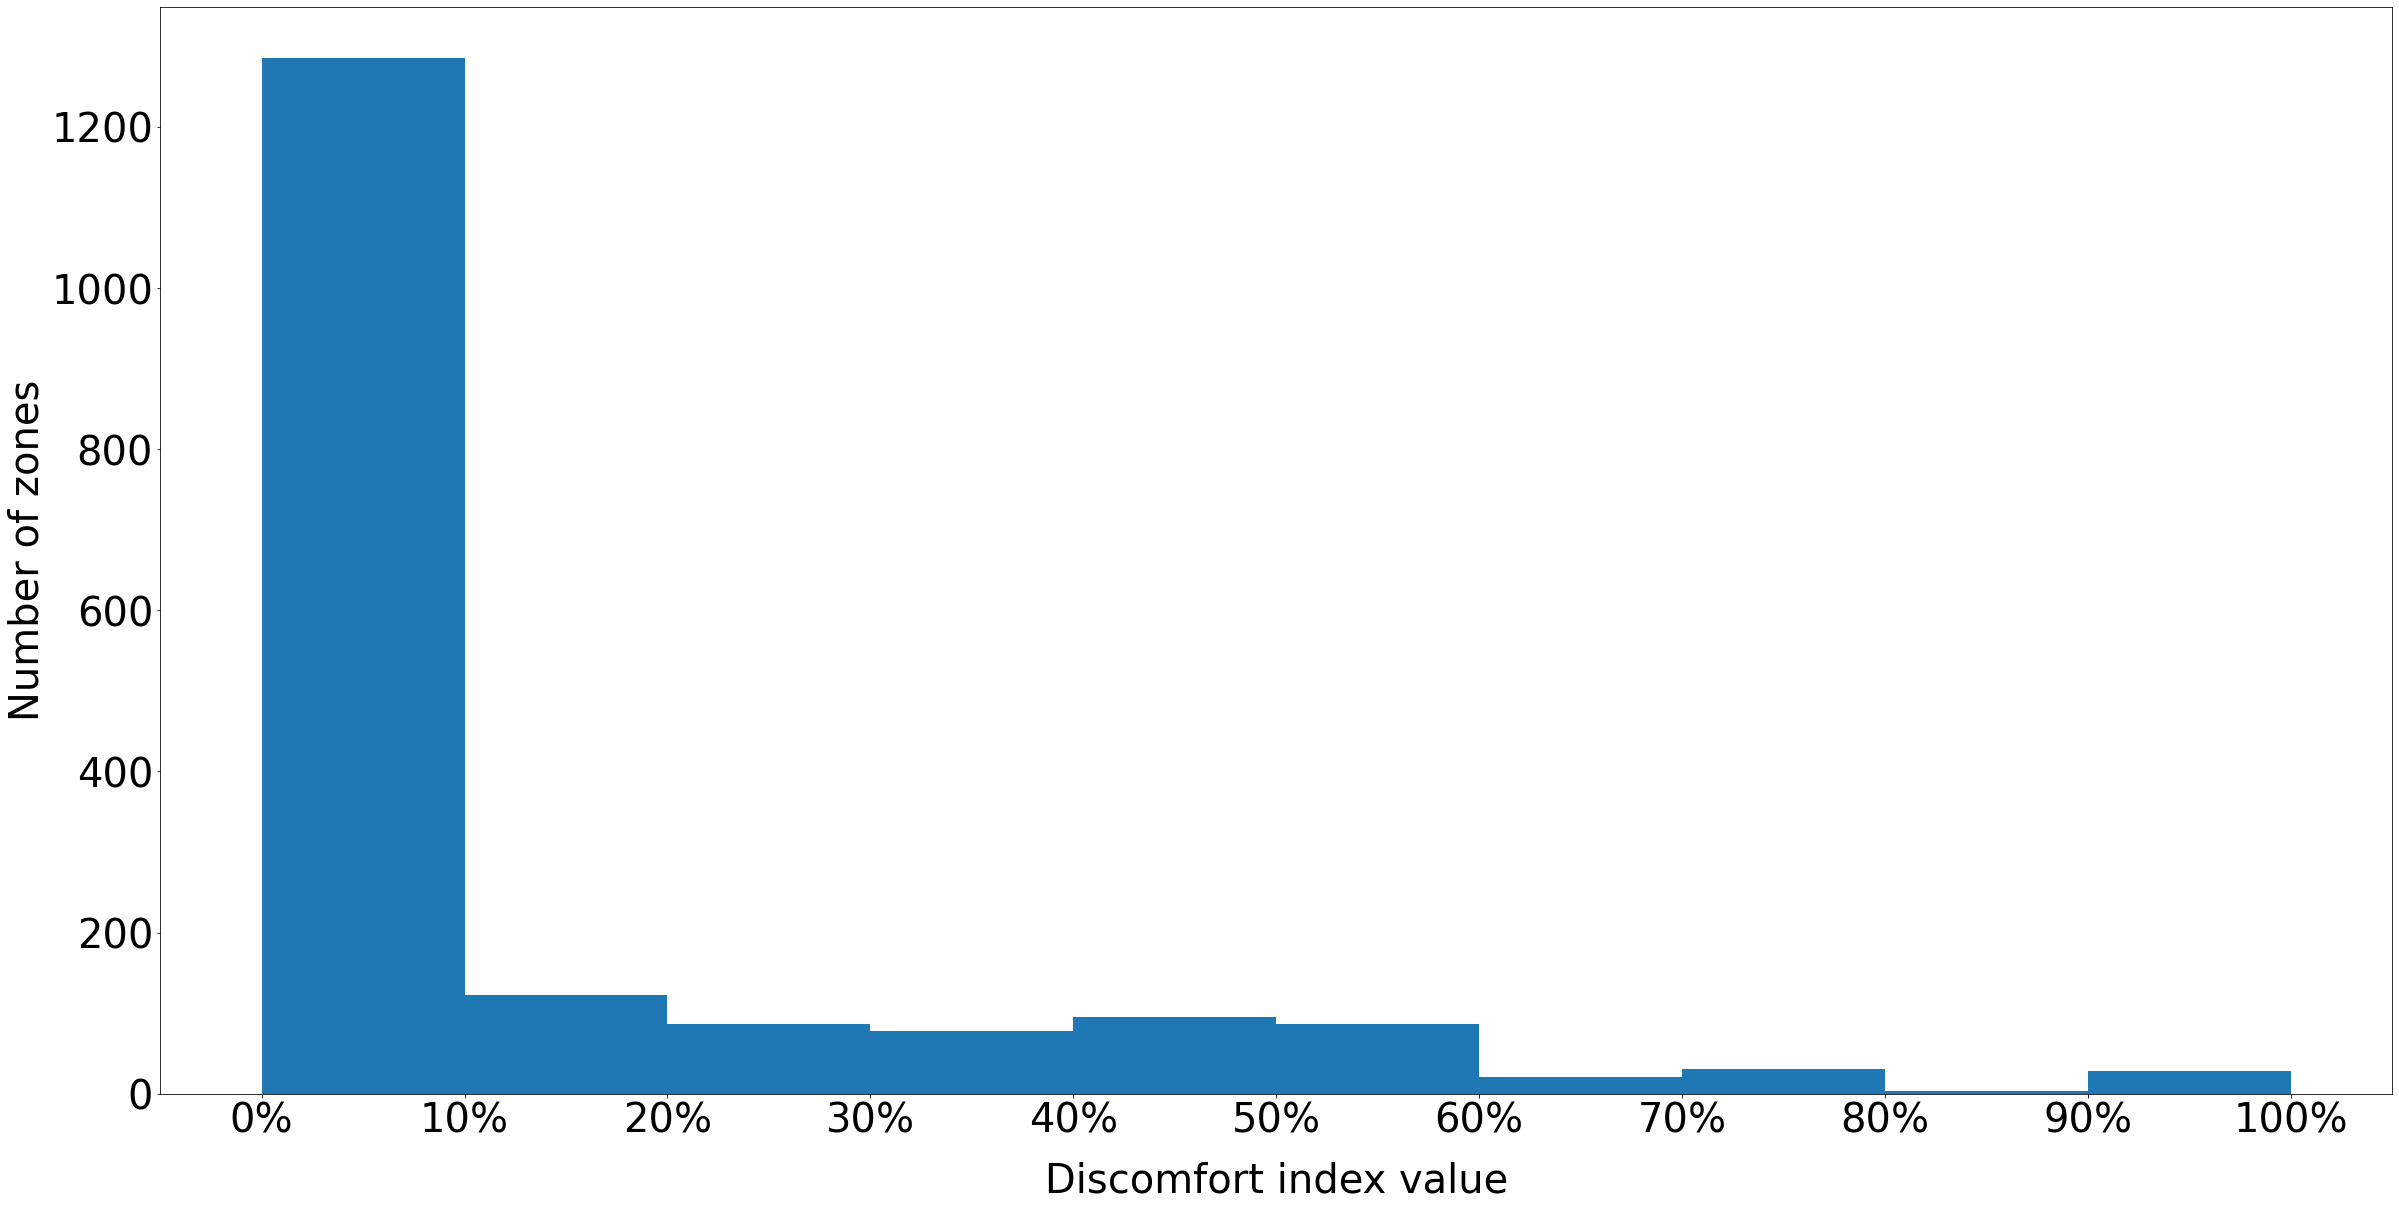

In [142]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import matplotlib.ticker as mtick

data = res_df['index']
n_bins = 10
# binwidth = 0.02
# n_bins = np.arange(min(data), max(data) + binwidth, binwidth)

fig, ax = plt.subplots(1, figsize=(40, 20))
ax.hist(data, bins=n_bins)
# plt.hist(data, bins=n_bins, weights=np.ones(len(data))/len(data))
ax.set_xlabel('Discomfort index value', fontsize=40, labelpad=20)
ax.set_ylabel('Number of zones', fontsize=40)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.tick_params(labelsize=40)
ax.grid(False)
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

<AxesSubplot:>

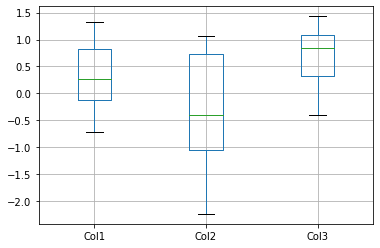

In [49]:
boxplot = dff.boxplot(column=['Col1', 'Col2', 'Col3'])

### integrating the comfort index with energy concern

In [13]:
# create multiple lists for storing results
res_dict = {}
# n_all is the number of zones that have summer or winter occupied data
# 
for i in ['n_all', 'p_sum', 'p_win', 'p_sum_lo', 'p_sum_up', 'p_win_lo', 'p_win_up',]:
    res_dict[i] = []
# evaluate each zone air temperature sensor data
for idxi, row in metadata_all.iterrows():
    meta_sensor = client.data_uris([row['sensor']])
    df = meta_sensor.data
    # parse the hour and weekday info and add it as a column
    df['hr'] = pd.to_datetime(df['time']).dt.hour
    df['wk'] = pd.to_datetime(df['time']).dt.dayofweek
    df['mo'] = pd.to_datetime(df['time']).dt.month
    # create occupied df by normal office hours and by weekdays
    df_occ = df[(df['hr'] >= 9) & (df['hr'] < 17) &
                (df['wk'] >= 0) & (df['wk'] <= 4)]
    # split the occupied data to the summer and  winter
    df_occ_sum = df_occ[(df_occ['mo'] >= 6) & (df_occ['mo'] <= 8)]
    df_occ_win = df_occ[(df_occ['mo'] >= 12) | (df_occ['mo'] <= 2)]
    
    # create lower and upper the temperature range df
    df_sum_lo = df_occ_sum[(df_occ_sum['value'] < 71.6)]
    df_sum_up = df_occ_sum[(df_occ_sum['value'] > 80.6)]
    df_win_lo = df_occ_win[(df_occ_win['value'] < 66.2)]
    df_win_up = df_occ_win[(df_occ_win['value'] > 77)]
    
    # the number of summer and winter occupied time
    n_occ_sum = len(df_occ_sum)
    n_occ_win = len(df_occ_win)
    n_occ_all = n_occ_sum + n_occ_win
    
    # the number of out of range summer occupied time
    n_sum_lo = len(df_sum_lo)
    n_sum_up = len(df_sum_up)
    n_sum_out = n_sum_lo + n_sum_up
    
    # the number of out of range winter occupied time
    n_win_lo = len(df_win_lo)
    n_win_up = len(df_win_lo)
    n_win_out = n_win_lo + n_win_up
    
    # calculate the percentage of out of range summer occupied time in all
    if n_occ_all != 0:
        res_dict['n_all'] += [1]
        p_sum = n_sum_out / n_occ_all
        p_win = n_win_out / n_occ_all

    # calculate the percentage of upper/lower of range occupied time in summer
    if n_occ_sum != 0:
        p_sum_lo = n_sum_lo / n_occ_sum
        p_sum_up = n_sum_up / n_occ_sum
        
    # calculate the percentage of upper/lower of range occupied time in  winter
    if n_occ_win != 0:
        p_win_lo = n_win_lo / n_occ_win
        p_win_up = n_win_up / n_occ_win
    
    # store the result into a 2d list
    res_dict['p_sum'] += [round(p_sum, 2)]
    res_dict['p_win'] += [round(p_win, 2)]
    res_dict['p_sum_lo'] += [round(p_sum_lo, 2)]
    res_dict['p_sum_up'] += [round(p_sum_up, 2)]
    res_dict['p_win_up'] += [round(p_win_up, 2)]
    res_dict['p_win_up'] += [round(p_win_up, 2)]

### Calculating Runtime

In [3]:
%%time
import pandas as pd
import re
import pymortar
# connect client to Mortar frontend server
client = pymortar.Client("https://beta-api.mortardata.org")

query = """SELECT ?sensor ?vav ?zone WHERE {{
    ?sensor a brick:Zone_Air_Temperature_Sensor .
    ?sensor brick:isPointOf ?vav .
    ?vav brick:feeds ?zone .
    ?zone a brick:HVAC_Zone .
}}"""

# get which sites return results for the query above
qualify_resp = client.qualify([query])
print("Mortar has {0} qualifed sites".format(len(qualify_resp.sites)))
print(qualify_resp.sites)

# get the brick metadata of the query sensors across all sites, except 'artx'
metadata_all = client.sparql(query, sites=qualify_resp.sites[1:])

# create multiple lists for storing results
res_dict = {}
# n_all is the number of zones that have summer or winter occupied data
# 
for i in ['p_out', 'p_sum_out', 'p_win_out', 'p_sum_lo', 'p_win_up']:
    res_dict[i] = []
# evaluate each zone air temperature sensor data
for idxi, row in metadata_all.iterrows():
    print("running on zone:", row['zone'])
    meta_sensor = client.data_uris([row['sensor']])
    df = meta_sensor.data
    # parse the hour and weekday info and add it as a column
    df['hr'] = pd.to_datetime(df['time']).dt.hour
    df['wk'] = pd.to_datetime(df['time']).dt.dayofweek
    df['mo'] = pd.to_datetime(df['time']).dt.month
    # create occupied df by normal office hours and by weekdays
    df_occ = df[(df['hr'] >= 9) & (df['hr'] < 17) &
                (df['wk'] >= 0) & (df['wk'] <= 4)]
    # split the occupied data to the summer and  winter
    df_occ_sum = df_occ[(df_occ['mo'] >= 6) & (df_occ['mo'] <= 8)]
    df_occ_win = df_occ[(df_occ['mo'] >= 12) | (df_occ['mo'] <= 2)]
    
    # create lower and upper the temperature range df
    df_sum_lo = df_occ_sum[(df_occ_sum['value'] < 71.6)]
    df_sum_up = df_occ_sum[(df_occ_sum['value'] > 80.6)]
    df_win_lo = df_occ_win[(df_occ_win['value'] < 66.2)]
    df_win_up = df_occ_win[(df_occ_win['value'] > 77)]
    
    # the number of summer and winter occupied time
    n_occ_sum = len(df_occ_sum)
    n_occ_win = len(df_occ_win)
    n_occ_all = n_occ_sum + n_occ_win
    
    # the number of outsite range summer occupied time
    n_sum_lo = len(df_sum_lo)
    n_sum_up = len(df_sum_up)
    n_sum_out = n_sum_lo + n_sum_up
    
    # the number of outsite range winter occupied time
    n_win_lo = len(df_win_lo)
    n_win_up = len(df_win_lo)
    n_win_out = n_win_lo + n_win_up
    
    # the number of outsite range simmer and winter occupied time
    n_out = n_sum_out + n_win_out
    
    # calculate the percentage of outsite range occupied time
    if n_occ_all != 0:
        p_out = n_out / n_occ_all
        # store the result into a 2d list
        res_dict['p_out'] += [round(p_out, 2)]
    
    # calculate the percentage of outsite range summer occupied time
    if n_out != 0:
        p_sum_out = n_sum_out / n_out
        p_win_out = n_win_out / n_out
        res_dict['p_sum_out'] += [round(p_sum_out, 2)]
        res_dict['p_win_out'] += [round(p_sum_out, 2)]
    
    # calculate the percentage of lower the range occupied time in summer
    if n_sum_out != 0:
        p_sum_lo = n_sum_lo / n_sum_out
        res_dict['p_sum_lo'] += [round(p_sum_lo, 2)]
        
    # calculate the percentage of upper the range occupied time in winter
    if n_win_out != 0:
        p_win_up = n_win_up / n_win_out
        res_dict['p_win_up'] += [round(p_win_up, 2)]
    
    print(res_dict['p_out'][-1], res_dict['p_sum_out'][-1], res_dict['p_win_out'][-1], res_dict['p_sum_lo'][-1], res_dict['p_win_up'][-1])

Mortar has 25 qualifed sites
['artx', 'bwfp', 'chem', 'chemx', 'crus', 'dh', 'fdpd', 'gbsf', 'gha_ics', 'giedt', 'hart', 'hwc', 'mann', 'msb', 'music', 'roes', 'stor', 'thur', 'veih', 'vm3a', 'vmep', 'vmif', 'vmth', 'well', 'wsrc']
running on zone: http://buildsys.org/ontologies/BWFP#RM1130A_MIX
0.49 0.98 0.98 0.0 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1203
0.01 1.0 1.0 1.0 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1107
0.3 1.0 1.0 1.0 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1130C_MIX
0.23 1.0 1.0 0.0 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1101_MIX
0.14 0.47 0.47 0.51 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1201
0.49 0.16 0.16 0.82 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1201_MIX
0.47 0.16 0.16 0.78 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1205S
0.5 1.0 1.0 1.0 0.5
running on zone: http://buildsys.org/ontologies/BWFP#RM1100
0.08 0.92 0.92 1.0 0.5
running o

# Drawing

In [6]:
x1 = res_dict['p_out']
x2 = res_dict['p_sum_out']
x3 = res_dict['p_win_out']
x4 = res_dict['p_sum_lo']
x5 = res_dict['p_win_up']

In [8]:
for i in [x1, x2, x3, x4, x5]:
    print(len(i))

1407
1297
1297
1289
805


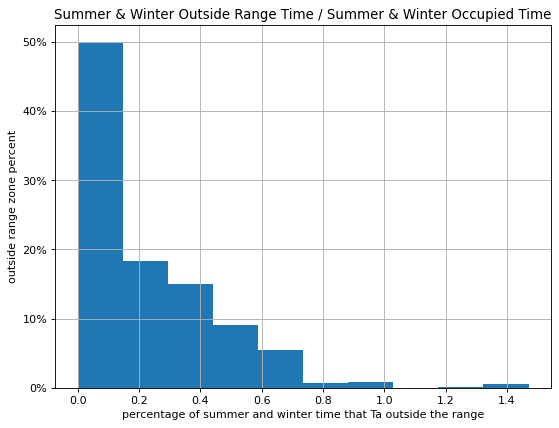

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x1, bins=10, weights=np.ones(len(x1))/len(x1))
plt.xlabel('percentage of summer and winter time that Ta outside the range')
plt.ylabel('outside range zone percent')
plt.title('Summer & Winter Outside Range Time / Summer & Winter Occupied Time')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

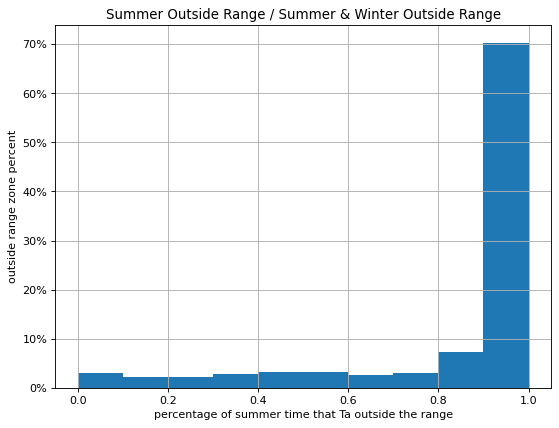

In [28]:

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x2, bins=10, weights=np.ones(len(x2))/len(x2))
plt.xlabel('percentage of summer time that Ta outside the range')
plt.ylabel('outside range zone percent')
plt.title('Summer Outside Range / Summer & Winter Outside Range')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

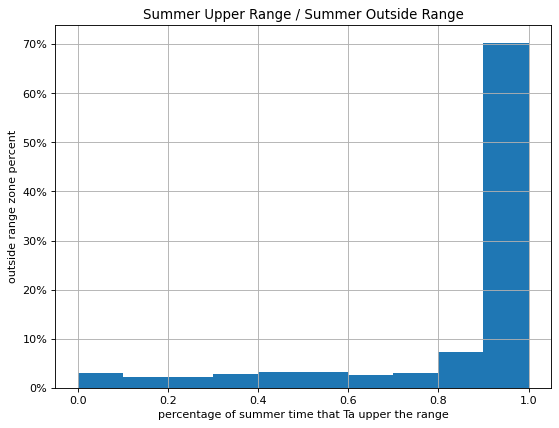

In [27]:

plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x3, bins=10, weights=np.ones(len(x3))/len(x3))
plt.xlabel('percentage of summer time that Ta upper the range')
plt.ylabel('outside range zone percent')
plt.title('Summer Upper Range / Summer Outside Range')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

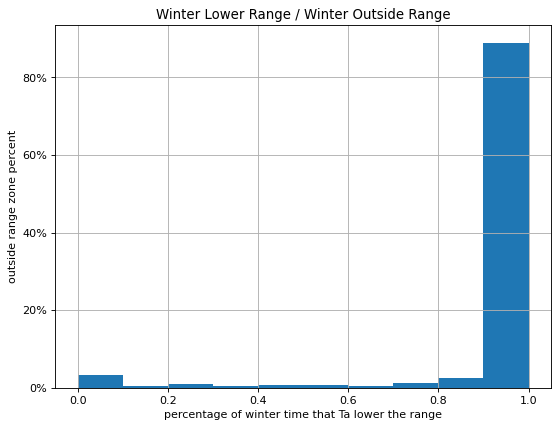

In [30]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x4, bins=10, weights=np.ones(len(x4))/len(x4))
plt.xlabel('percentage of winter time that Ta lower the range')
plt.ylabel('outside range zone percent')
plt.title('Winter Lower Range / Winter Outside Range')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

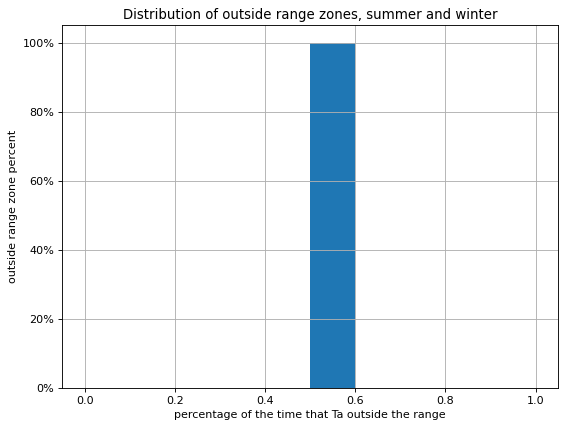

In [21]:
plt.figure(figsize=(8, 6), dpi=80)
plt.hist(x5, bins=10, weights=np.ones(len(x5))/len(x5))
plt.xlabel('percentage of the time that Ta outside the range')
plt.ylabel('outside range zone percent')
plt.title('Distribution of outside range zones, summer and winter')
plt.grid(True)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

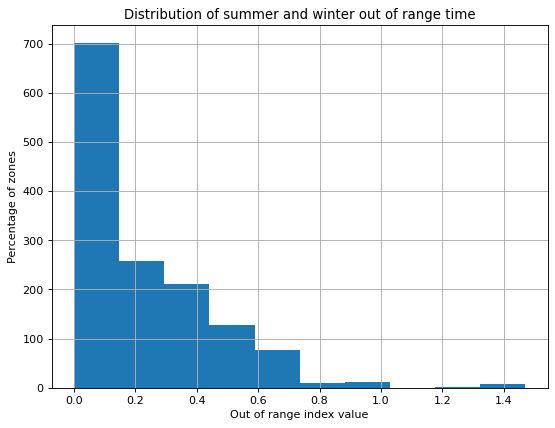

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
colors = ['red', 'blue']
labels = ['summer', 'winter']
plt.hist(x, bins=10, histtype='bar', color=colors, label=labels)
plt.xlabel('Out of range index value')
plt.ylabel('Percentage of zones')
plt.title('Distribution of summer and winter out of range time')
plt.legend(prop={'size': 10})
plt.grid(True)
plt.show()

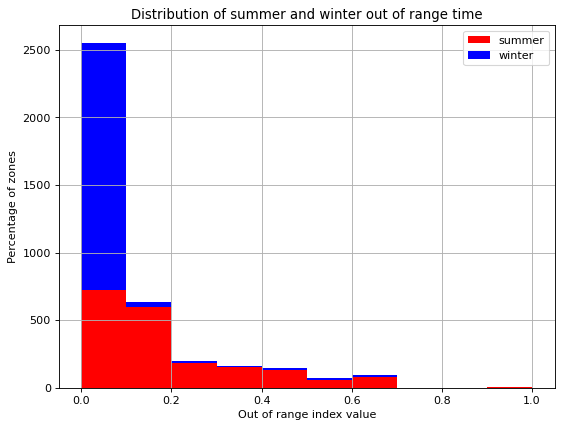

In [62]:
plt.figure(figsize=(8, 6), dpi=80)

colors = ['red', 'blue']
labels = ['summer', 'winter']
plt.hist(x, bins=10, histtype='bar', stacked=True, color=colors, label=labels)
plt.xlabel('Out of range index value')
plt.ylabel('Percentage of zones')
plt.title('Distribution of summer and winter out of range time')
plt.legend(prop={'size': 10})
plt.grid(True)
plt.show()


In [41]:
x = []
for i in range(len(x11)):
    x += [[x11[i], x12[i], x21[i], x22[i], x31[i], x32[i]]]

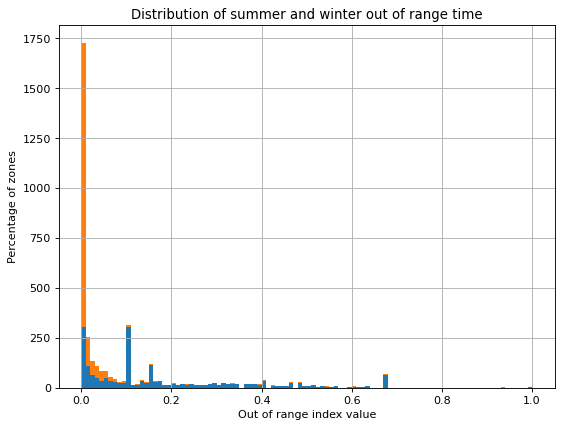

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.hist([x11, x12], bins=100, stacked=True)
plt.xlabel('Out of range index value')
plt.ylabel('Percentage of zones')
plt.title('Distribution of summer and winter out of range time')
plt.grid(True)
plt.show()

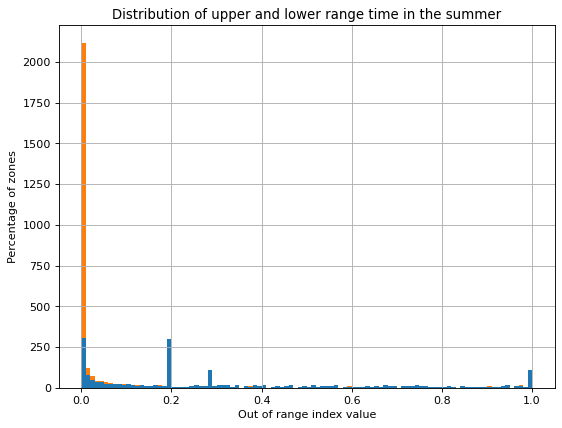

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.hist([x21, x22], bins=100, stacked=True)
plt.xlabel('Out of range index value')
plt.ylabel('Percentage of zones')
plt.title('Distribution of upper and lower range time in the summer')
plt.grid(True)
plt.show()

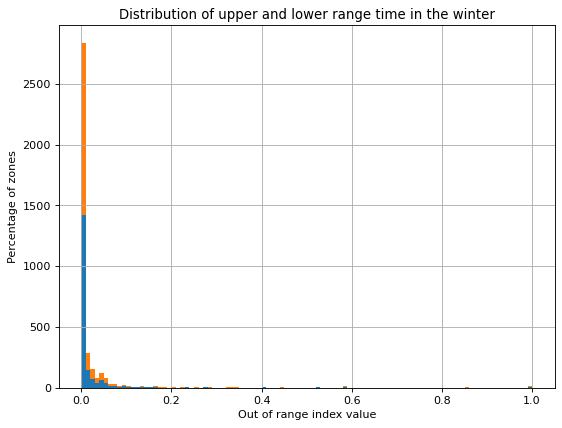

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.hist([x31, x32], bins=100, stacked=True)
plt.xlabel('Out of range index value')
plt.ylabel('Percentage of zones')
plt.title('Distribution of upper and lower range time in the winter')
plt.grid(True)
plt.show()

In [52]:
x = np.random.randn(1000, 3)

In [54]:
x

array([[-1.09236994,  1.21318092,  0.57949423],
       [-0.05705587, -1.14529652,  2.47896275],
       [ 1.81537273,  0.41885683,  0.92602234],
       ...,
       [ 2.25776326,  0.4369307 , -2.07665069],
       [-0.67152279,  1.33325522,  2.1701308 ],
       [-0.00341434,  2.18396995,  1.43632346]])

In [51]:
x

array([[0.47, 0.01],
       [0.01, 0.  ],
       [0.3 , 0.  ],
       ...,
       [0.05, 0.  ],
       [0.01, 0.  ],
       [0.49, 0.  ]])

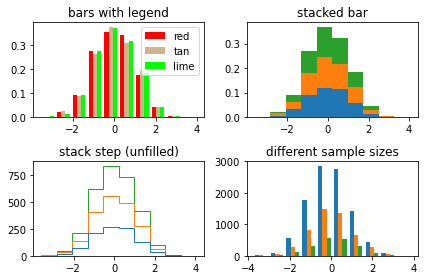

In [29]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)

n_bins = 10


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2)

colors = ['red', 'tan', 'lime']
ax0.hist(x, n_bins, density=True, histtype='bar', color=colors, label=colors)
ax0.legend(prop={'size': 10})
ax0.set_title('bars with legend')

ax1.hist(x, n_bins, density=True, histtype='bar', stacked=True)
ax1.set_title('stacked bar')

ax2.hist(x, n_bins, histtype='step', stacked=True, fill=False)
ax2.set_title('stack step (unfilled)')

# Make a multiple-histogram of data-sets with different length.
x_multi = [np.random.randn(n) for n in [10000, 5000, 2000]]
ax3.hist(x_multi, n_bins, histtype='bar')
ax3.set_title('different sample sizes')

fig.tight_layout()
plt.show()

In [ ]:
plt.hist([x1,x2,x3], bins, stacked=True, density=True)

In [8]:
# get dataset with URIs
query_res = client.data_uris(["http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp"])
query_res.data

,time,value,id
0,2012-04-18 23:45:00+00:00,79.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
1,2012-04-18 23:30:00+00:00,78.75,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
2,2012-04-18 23:15:00+00:00,79.75,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
3,2012-04-18 23:00:00+00:00,79.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
4,2012-04-18 22:45:00+00:00,78.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
...,...,...,...
227245,2017-11-30 22:30:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
227246,2017-11-30 22:15:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
227247,2017-11-30 22:00:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
227248,2017-11-30 21:45:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....


In [5]:
query_res

In [21]:
start = "2015-01-01T00:00:00Z"
end = "2015-12-31T00:00:00Z"
window = 15
sensor_df = client.data_uris(["http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp"], start=start, end=end, agg='mean', window="{}m".format(window))

In [22]:
sensor_df.data

,time,value,id
0,2015-01-01 00:00:00+00:00,60.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
1,2015-01-01 00:15:00+00:00,60.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
2,2015-01-01 00:30:00+00:00,60.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
3,2015-01-01 00:45:00+00:00,59.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
4,2015-01-01 01:00:00+00:00,59.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
...,...,...,...
100174,2017-12-29 08:15:00+00:00,64.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
100175,2017-12-29 08:30:00+00:00,64.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
100176,2017-12-29 08:45:00+00:00,64.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....
100177,2017-12-29 09:00:00+00:00,64.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE....


In [93]:
# df.reset_index(drop=True)
# df = data.set_index(['time'])
# df.sort_index(inplace=True, ascending=True)
# df = df[start_date:end_date]

In [95]:
# parse the hour and weekdays info from the datetime column
df['hour'] = pd.to_datetime(df['time']).dt.hour
df['weekday'] = pd.to_datetime(df['time']).dt.dayofweek

<ipython-input-95-f1b87f66776d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_datetime(df['time']).dt.hour
<ipython-input-95-f1b87f66776d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weekday'] = pd.to_datetime(df['time']).dt.dayofweek


In [105]:
# create a new dataframe for the specified office hours and weekdays
df_occ = df[(df['hour'] >= a) & (df['hour'] < b) &
            (df['weekday'] >= 0) & (df['weekday'] <= 4)]
df_occ

,time,value,id,hour,weekday
101185,2016-01-20 16:45:00+00:00,72.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,16,2
101186,2016-01-20 16:30:00+00:00,72.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,16,2
101187,2016-01-20 16:15:00+00:00,72.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,16,2
101188,2016-01-20 16:00:00+00:00,72.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,16,2
101189,2016-01-20 15:45:00+00:00,72.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,15,2
...,...,...,...,...,...
204037,2016-01-21 10:00:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,10,3
204038,2016-01-21 09:45:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3
204039,2016-01-21 09:30:00+00:00,69.75,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3
204040,2016-01-21 09:15:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3


In [108]:
df_out = df_occ[(df_occ['value'] < l) | (df_occ['value'] > u)]
df_out

,time,value,id,hour,weekday
101195,2016-01-20 14:15:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,14,2
101196,2016-01-20 14:00:00+00:00,70.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,14,2
101197,2016-01-20 13:45:00+00:00,70.50,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,13,2
101198,2016-01-20 13:30:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,13,2
101199,2016-01-20 13:15:00+00:00,71.00,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,13,2
...,...,...,...,...,...
204037,2016-01-21 10:00:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,10,3
204038,2016-01-21 09:45:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3
204039,2016-01-21 09:30:00+00:00,69.75,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3
204040,2016-01-21 09:15:00+00:00,70.25,http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp,9,3


In [109]:
p = len(df_out) / len(df_occ)
p

0.8869047619047619

In [125]:
a='Beautiful, is; better*than\nugly'
import re
re.split('; |, |\*|\n',a)[-1]

'ugly'

In [120]:
id

'http://buildsys.org/ontologies/ARTX#ARTX.ZONE.AHU02.RM103.Zone_Air_Temp'

In [127]:
import re
# input sensors' metadata to thermal comfort index calculation package
for id in site_metadata.sensor:
    zone_name = re.split('[.]', id)[-2]
    

RM103
RM107B
RM112
RM110
RM115
RM120
RM100
RM107A
